# Section 2: Data Exploration and Cleaning

## Importing the data

In [20]:
ww=pd.read_csv(r'water_well.csv') #The water point data we're provided
wt=pd.read_csv(r'water_well_target.csv') #The status of each water point, also provided
wwdf=ww.merge(wt,on='id',validate='one_to_one') # Combining the two dataframes, useful for initial EDA

In [21]:
wwdf

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,3/14/2011,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,3/6/2013,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2/25/2013,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,1/28/2013,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,7/13/2011,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,10.0,5/3/2013,Germany Republi,1210,CES,37.169807,-3.253847,Area Three Namba 27,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
59396,27263,4700.0,5/7/2011,Cefa-njombe,1212,Cefa,35.249991,-9.070629,Kwa Yahona Kuvala,0,...,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional
59397,37057,0.0,4/11/2011,NaN,0,NaN,34.017087,-8.750434,Mashine,0,...,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,functional
59398,31282,0.0,3/8/2011,Malec,0,Musa,35.861315,-6.378573,Mshoro,0,...,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional


# Section 3: Model Selection

### To enable this section to be ran by itself, we import our needed modules and cleaned data again:

###  Modules:

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import urllib.request
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector

from sklearn.inspection import permutation_importance

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from joblib import dump, load
from os import path

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import make_scorer, recall_score

### Dataset:

In [23]:
wwdf=pd.read_csv('cleaned_waterpoint_data.csv')
try:
    wwdf.set_index('id',inplace=True)
except:
    print('index probably already set')
    
#being sure things look right:
wwdf.head(3)

,amount_tsh,funder,installer,longitude,latitude,basin,subvillage,region,region_code,district_code,...,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,elevation,time_interval,water_quality_character,water_quality_abandoned
id,,,,,,,,,,,,,,,,,,,,,
69572,8.699681,ROMAN,ROMAN,34.938093,-9.856322,LAKE NYASA,MNYUSI B,IRINGA,11,5,...,SPRING,SPRING,GROUNDWATER,COMMUNAL STANDPIPE,COMMUNAL STANDPIPE,FUNCTIONAL,1390.0,12.0,SOFT,0
8776,0.000000,GRUMETI,GRUMETI,34.698766,-2.147466,LAKE VICTORIA,NYAMARA,MARA,20,2,...,RAINWATER HARVESTING,RAINWATER HARVESTING,SURFACE,COMMUNAL STANDPIPE,COMMUNAL STANDPIPE,FUNCTIONAL,1399.0,3.0,SOFT,0
34310,3.258097,ROTARY CLUB,WORLD VISION,37.460664,-3.821329,PANGANI,MAJENGO,MANYARA,21,4,...,DAM,DAM,SURFACE,COMMUNAL STANDPIPE MULTIPLE,COMMUNAL STANDPIPE,FUNCTIONAL,686.0,4.0,SOFT,0


### Functions:

In [25]:
#A function to automate creation of the column transformers we'll need

def prepare_cts(df,scaler,fill_value_input='none',fill_value_strategy='constant'):
    '''
    takes in df, scaler, fill_value_input,fill_value_strategy
    outputs transformers to handle imputing categorical variables and onehotencoding & doing specified numerical scaling.
    
    All data should be string or numeric. Output will be two transformeres, which will appropriately handle mixed data:
    
    imputer_transformer,encode&scale_transformer.
    
    Passing multiple scalers might work???? Why would you even do that though.  But it probably would.  But only if you're
    applying it to everything.  Otherwise, pass another column transformer after the fact and uh good luck with that lmao.
    
    the kw definitions are open and obvious, but be careful as some of the safeguards are gone.
    OneHotEncoder is fixed with unknown_values='ignore'
    '''
    print("if  you forgot to set up an assignment or save you should probably hit interrupt and do that now")
    number_cols_initial=[df.columns.get_loc(c) for c in df.select_dtypes(include='number')]
    cat_cols_initial=[df.columns.get_loc(c) for c in df.select_dtypes(exclude='number')]
    
    ctoheimp=ColumnTransformer([('impute',SimpleImputer(strategy=fill_value_strategy,
                                                        fill_value=fill_value_input),cat_cols_initial)]
                               ,remainder='passthrough')
    
    
    ctohe2=ColumnTransformer([('OHE',OneHotEncoder(handle_unknown='ignore',sparse=False),slice(0,len(cat_cols_initial))),
                              ('rescale num2',scaler,slice(len(cat_cols_initial),
                                                                                      df.shape[1]))],
                             remainder='passthrough')     
    
    return ctoheimp,ctohe2


#The function used to save files that was used-- not actually ran here, but given for context & to enable further user
#work within the notebook in the same way the initial work was done.

def safe_pickle(model,filepath):
    '''
    Used to safely store models-- will prompt if the filename already exists
    '''
    print("be sure you have .joblib at the end")
    if path.exists(filepath):
        if input('type anything but "okay" to break ')!='okay':
            return('broken')

    dump(model,filepath)
    return('done')

# The scoring function used, explain in the section immediately following this one.
skrilla_scorer=make_scorer(recall_score,labels=['NON FUNCTIONAL','FUNCTIONAL NEEDS REPAIR'],average='weighted')


#Used for automatic feature selection, explained further below
be_wary=['population','installer','subvillage','lga','funder']

consider=[c for c in ['elevation','amount_tsh','public_meeting','permit','time_interval','longitude','latitude','water_quality_character','water_quality_abandoned']]
exclusives=[['basin','subvillage','region','region_code','district_code','lga','ward'],
 ['scheme_management','scheme_name'],
 ['extraction_type_group','extraction_type_class','extraction_type'],
 ['management','management_group'],
 ['payment_type','payment'],
 ['water_quality','quality_group'],
 ['quantity','quantity_group'],
 ['source_class','source','source_type'],
 ['waterpoint_type','waterpoint_type_group']
]
avoid_list=be_wary
pick_one=[]

for c in exclusives:
    g=[(k,wwdf[k].nunique()) for k in c]

    for u in g:
        if u[1]>100:
            avoid_list.append(u[0])

    pick_one.append([l[0] for l in g if l[1]<100])

def primitive_feature_grab():
    feature_list=[]
    for c in consider:
        if np.random.uniform()>.5:
            feature_list.append(c)
    for c in pick_one:
        feature_list.append(np.random.choice(c))

    return feature_list

## Searching for a useful model

### The Performance Metric:

The ultimate goal being sought is to create a model that is useful for business planning, to make entering the space or expanding within the space a more attractive prospect.  As such, we seek our model to provide a way to mitigate *risk* and lower *overhead* for the user.  Bearing this in mind, we will select models based on their recall score across two categories: 'NON FUNCTIONAL' and 'FUNCTIONAL NEEDS REPAIR'.  

This should optimize our models in the direction of reducing the chance of the model incorrectly predicting that a given point will need maintenance work when it in fact does not.  The thinking guiding this is that it's significantly worse to **over** order than to **under** order. If you run the model on a collection of waterpoints and mistakenly believe that some don't need work which do then at worst, if you have no excess capacity anyway, you've just lost out on business opportunities that you'll hopefully be able to follow up on later.   If you run the model on a collection of waterpoints and instead **over** estimate demand, you'll hire too many people and will have acquired materials that may not be needed, which is potentially quite harmful to business viability.  

We therefore choose our model scoring to be the recall score for the average of the two aforementioned categories, weighting for the number of instances of that category present in the target set.  The nature of the data suggests that we have a fairly representative sample of the overall distribution of waterpoints-- if any class would be artificially represented, it would of course be those in need of repair but still functioning-- and so we seek to *account for*, rather than *mitigate*, the class imbalance that emerges from the small size of 'functioning needs repair' relative to the other two classes. 

The actual scoring function, defined exactly as outlined here, is defined in the block above where all other functions are defined.

## Features used:

It was unclear what features would be best to use.  Reviewing relevant literature revealed that some features that may not intuitively seem important, such as the way in which people are charged to use the waterpoint, are in fact quite tightly bound to the eventual outcome of a waterpoint's status.  Consequently, while some a priori reasoning was used for specific feature sets tried, the general approach was heavily exploratory. 

The nature of the data, in particular the large number of features that were either very tightly related to eachother or were reporting the same physical properties at different levels of granularity, helped guide the selection in a few ways:

1. It is not computationally feasible to try out all features simultaneously (perhaps followed by automated pruning)
2. It is inadvisable to include large groups of features together, as substantial overlap in underlying phenomena is likely present
3. There is a clear way in which to make some feature selection: Move up or down the implicit hierarchies.

Two sets of explicitly defined features were given particular attention:
` ['basin','extraction_type','latitude','longitude','payment_type','water_quality_character','water_quality_abandoned'] `, 
chosen for simplicity and with some a priori consideration on what seemed likely to matter, and 

` ['elevation', 'amount_tsh', 'public_meeting', 'time_interval',
       'water_quality_character', 'region', 'scheme_management',
       'extraction_type_group', 'management', 'payment_type', 'water_quality',
       'quantity', 'source', 'waterpoint_type_group'] `
       
 Chosen through a combination of features found through the random-search method described below and a bit of a priori consideration. 
 
 As alluded to, random combinations were also tried, selecting individual elements from sets thought to represent different levels of description.  In this process, Population was neglected due to the data being inferior with no obvious way to successfully be filled, and "installer", "subvillage", "lga", and "funder" due to being categorical features with tremendously high categories counts, rendering modelling with them infeasible for locally available resources.

## Searching for a model

A few examples of how this process was carried out follow below.  Actually running these cells is extremly time consuming.  We provide them for illustrative purposes; all the examples below are given at the end of this section in a saved .joblib file that can be loaded to mitigate the actual time required to move through this section.  When working, an empty list was first initiated, called 'memo', and the results of each training were appended to that.  An example of this being done is given in the first example.

First, we'll see the process used to try out training a model, here a K-Neigbors Classifier model, on our purely a priori considered feature set:

In [ ]:
X=wwdf.copy()[['basin','extraction_type','latitude','longitude','payment_type','water_quality_character','water_quality_abandoned']]
y=wwdf.copy()['status_group']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.2,random_state=60120)
imp,enc=prepare_cts(X_train,StandardScaler())
#defining the imputation & scaling column transformers


#sdefining the model
clf=KNeighborsClassifier()



pipeline=Pipeline([('impute categorical',imp),('encode&scale',enc),
                   ('KNN impute',KNNImputer()),('fxn',clf)])

pipeline.fit(X_train,y_train)

cv_score=cross_val_score(pipeline,X_train,y_train,cv=3,scoring=skrilla_scorer)


# memo.append({'name':'KNN on first set','cv_results':pd.DataFrame(search.cv_results_),'best_estimator':search.best_estimator_,
# 'best_score':search.best_score_,'best_score':'NA','train_score':search.score(X_train,y_train),'test_score':search.score(X_test,y_test),'feature_list':ideal_set})


    
#Be careful with the scores, they're different for the .score method

#The saving function used on a per-model basis, included for illustrative purposes:

# safe_pickle(clf,f'knn_vanilla.joblib')


#the memo appending, as mentioned above:

#     memo.append({'name':f'K Neighbors on hand-selected set','cv_results':cv_score,'best_estimator':pipeline,
#     'train_score':pipeline.score(X_train,y_train),'test_score':pipeline.score(X_test,y_test),
#                     'feature_list':X.columns})

This was done for most of the popular classification-amenable machine learning algorithms in their vanilla (sklearn default settings) form: Logistic Regression, Decision Tree Classifiers, Random Forest Classifiers, XGBoosted classification, and Naive Bayes.  For Logistic Regression, the number of iterations had to be increased from the default of 100 to 500 in order to cause convergence (witht he default algorithm and L2 penalty).

It was anticipated ahead of time that trees would be the most effective avenue to explore, given the level of OHE necessary here, the runs over the known models helped bolster this suspicion and so analysis drilled-down on that.  

An example of looping a single feature set over a collection of classifiers is detailed here: 

In [ ]:
X=wwdf.copy()[['basin','extraction_type','latitude','longitude','payment_type','water_quality_character','water_quality_abandoned']]
y=wwdf.copy()['status_group']
#Defining the sets given

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.2,random_state=60120)
imp,enc=prepare_cts(X_train,MinMaxScaler())


names=['RFC_vanilla','DCT_vanilla','XGB_vanilla']
#Setting up the names for the save function and memo-appending given below

#setting up loop
for clf in [RandomForestClassifier(random_state=60120),DecisionTreeClassifier(random_state=60120),XGBClassifier(random_state=60120)]:
    #Supplying the list of classifiers
    
    name=names.pop(0)
    print(names)
    print(f'working on {name}, {clf}')
    #This takes forever.  As a sanity check, print functions are used throughout here to make one feel more confident
    #that things are actually working
    
    pipeline=Pipeline([('impute categorical',imp),('encode&scale',enc),
                       ('KNN impute',KNNImputer()),('fxn',clf)])
    print('fitting pipeline')
    pipeline.fit(X_train,y_train)
    print('doing cv score')
    cv_score=cross_val_score(pipeline,X_train,y_train,cv=3,scoring=skrilla_scorer)
    
#     memo.append({'name':f'{name}','cv_results':cv_score,'best_estimator':pipeline,
#     'best_score':'NA','train_score':pipeline.score(X_train,y_train),'test_score':pipeline.score(X_test,y_test),'feature_list':X.columns})

    
#Be careful with the scores, they're different for the .score method
#     safe_pickle(clf,f'{name}_vanilla.joblib')

#Bypassing the save, note as specified this loop will be re-assigning the "pipeline" variable and thus wont' do anything useful


Random grid searches were used on likely seeming avenues (feature+model combination), as shown here.  In particular, DecisionClassifierTrees and RandomForests were ran over with hyperparameter tuning on a few different sets. 

In [ ]:
X=wwdf.copy()[['basin','extraction_type','latitude','longitude','payment_type','water_quality_character','water_quality_abandoned']]
y=wwdf.copy()['status_group']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.2,random_state=60120)



imp,enc=prepare_cts(X_train,MinMaxScaler())

pipeline=Pipeline([('impute categorical',imp),('encode&scale',enc),('KNN impute',KNNImputer()),('fxn',
                                                                                               RandomForestClassifier(random_state=60120)
                                                                                               )])
param_grid={'fxn__n_estimators':[10,20,50,100,200,500],
            'fxn__max_depth':range(1,201,10),
            'fxn__criterion':['gini','entropy'],
            'fxn__min_samples_split':[2,4,5],
            'fxn__max_features':['auto','log2'],
            
           }

search=RandomizedSearchCV(pipeline,param_distributions=param_grid,n_iter=10,return_train_score=True,random_state=60120,
                         scoring=skrilla_scorer)


print('done searching')
#Again, one's sanity is maintained by including print functions between time-consuming steps
search.fit(X_train,y_train)
print('writing things into memo')

# memo.append({'name':'handpicked tuned DCT','cv_results':pd.DataFrame(search.cv_results_),'best_estimator':search.best_estimator_,
# 'best_score':search.best_score_,'train_score':search.score(X_train,y_train),'test_score':search.score(X_test,y_test),'feature_list':X.columns})

# print(search.best_score_)

# safe_pickle(search.best_estimator_,'handpicked_rcv_rfc.joblib')



An example of looping over different features, here with KNN, is given below.  The "primitive_feature_grab()" function is used to assign the list of features such that we examine a single element from each heiarchical group (e.g., geographical features except where otherwise noted) and then choosing with .5 probability whether or not to include each non-heiarchical feature.  There is no known advantage to randomly sampling the feature state like this guiding this decision (one may exist, but the authors lack awareness of this), rather the process is done for ease of automation. 

In [ ]:

#increase n, n_iter
clf=KNeighborsClassifier()
for n in range(0,10):

    X=wwdf.copy()[primitive_feature_grab()]
    y=wwdf.copy()['status_group']
    print(X.columns)

    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.2,random_state=60120)
    imp,enc=prepare_cts(X_train,MinMaxScaler())
    #Prep stuff
    
    name=f'feature_search_{n}'
    

    #setting up loop

    pipeline=Pipeline([('impute categorical',imp),('encode&scale',enc),
                       ('KNN impute',KNNImputer()),('fxn',clf)])
    print('fitting pipeline')
    pipeline.fit(X_train,y_train)
    print('doing cv score')
    cv_score=cross_val_score(pipeline,X_train,y_train,cv=3,scoring=skrilla_scorer)
    print(cv_score)

    
#     memo.append({'name':f'{name}','cv_results':cv_score,'best_estimator':pipeline,
#     'best_score':'na','train_score':pipeline.score(X_train,y_train),'test_score':pipeline.score(X_test,y_test),
#                     'feature_list':X.columns})


#     Be careful with the scores, they're different for the .score method
#     safe_pickle(clf,f'{name}.joblib')


The results of doing this with KNC and DCT (time constraints guiding this) were then used to "guess at" an ideal set, which in fact did seem to result in good performance and served as the feature set for later tuning. 

A snapshot of some models tried can be seen by loading the dataset below, many other models at aroud-the-same-or-worse performance levels were not recorded.

Notice that some models score better than the one ultimately used.  In the case of the KNN model, consistent use was deemed infeasible due to the time required for consistent use.  For many others, they were found after the initial model was selected, they're included because they're useful to consider but were found after further development of the model had to begin.  

Notice as well that the "train_score" and "test_score", while recorded, do not correspond to the score desired, rather they use the default scoring for the classifier given.  the cv_results were instead used, the format for which varies based on whether the model was found with tuning or specified directly. 

This dataframe is intended to be easily *accessible*, not easily *readable*. 

In [33]:
some_model_results=pd.read_csv('memo_snapshot.csv',index_col=0)
some_model_results.head(3)

,name,cv_results,best_estimator,best_score,train_score,test_score,feature_list
0,handpicked tuned DCT,mean_fit_time std_fit_time mean_score_tim...,"Pipeline(steps=[('impute categorical',\n ...",0.643798986,0.992208,0.655293,"Index(['basin', 'extraction_type', 'latitude',..."
1,RFC_vanilla,[0.64564315 0.62863071 0.63858921],"Pipeline(steps=[('impute categorical',\n ...",na,0.994886,0.739646,"Index(['basin', 'extraction_type', 'latitude',..."
2,DCT_vanilla,[0.62600277 0.61798064 0.62295989],"Pipeline(steps=[('impute categorical',\n ...",na,0.994949,0.706313,"Index(['basin', 'extraction_type', 'latitude',..."


A .joblib file is available, however it is too large to be hosted on github.  We would be happy to provide the file if requested, please feel free to contact over github or using the information provided in this repo.  Individual models can also be quickly recovered from the above, by calling the best_estimator and features_list information and supplying the random_state variable value 60120 anywhere needed

In [57]:
# sample_models=load('trial_7_30.joblib')
# sample_models_df=pd.DataFrame(sample_models)

#Example of recall use, quite slow to run in practice and not necessary for later cell execution

# samp_mod=(pd.DataFrame(sample_models).iloc[-1])['best_estimator']
# feat_set=(pd.DataFrame(sample_models).iloc[-1])['feature_list']
# X=wwdf.copy()[feat_set]
# samp_mod.predict(X)

The actual model, named "RFC_ideal_set" used can be loaded with:

In [117]:
working_model=load('rfc_on_ideal_set_bestpipe.joblib')

For the sake of convenience, we redefine the necessary sets accordingly:

In [118]:
ideal_set_X=pd.read_csv('ideal_set_X.csv',index_col='id')
X=ideal_set_X
X_train,X_test,y_train,y_test=train_test_split(ideal_set_X,y,test_size=.2,random_state=60120)

The model did not perform as well as would be ideal-- further work can absolutely be done.

In [111]:
#Seeing the cv results, notice the somewhat awkward-- but easily extensible-- call used
print('cv scores:')
print(((sample_models_df.loc[sample_models_df['name']=='RFC_on_ideal_set'][['cv_results']]).iloc[0])[0])
print('mean cv score:')
print((sample_models_df.loc[sample_models_df['name']=='RFC_on_ideal_set'][['cv_results']].iloc[0])[0].mean())

cv scores:
[0.67828492 0.66970954 0.67344398]
mean cv score:
0.6738128169663439


## Further model analysis
Feature importance for the model was calculated using the permutation_importance module in sklearn, imported above. Details can be found here: https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html

This turns out to be probably preferable to the normal feature_importance_, both theoretically and with an eye to pragmatics-- for both, especially when working with categorical features (especially especially with mixed features).  This is important for our applications, both because of the mixed feature types and also the wildly different cardinalities of the categorical features.

The function call that was used is given below and will run, however again we give an already-computer version that can instead be loaded. 

In [94]:
#The actual functions that can be ran to find these results.  Notice we only save the "importances" entry, as it's 
#trivial to restore the other two on the fly.

# FI_larger=permutation_importance(best_pipe,X_test,y_test,scoring=skrilla_scorer,n_repeats=10,random_state=60120)
# FI_larger_df=pd.DataFrame(FI_larger['importances'],index=X.columns)
# FI_larger_df.to_csv('larger_FI.csv')

FI_loaded=pd.read_csv('larger_FI.csv',index_col=0)
FI_loaded.head(3)

,0,1,2,3,4,5,6,7,8,9
elevation,0.055036,0.057604,0.048431,0.057971,0.050449,0.056320,0.062190,0.063291,0.056320,0.055586
amount_tsh,0.036507,0.033205,0.034673,0.034489,0.036691,0.037057,0.035773,0.034673,0.035039,0.035039
public_meeting,0.009906,0.009356,0.009356,0.010824,0.008072,0.006971,0.009173,0.008806,0.010457,0.009356


Visualizing the feature importances requires a bit of finangling to get seaborn to easily show the results.  This is done here:

In [101]:
#adapted from https://stackoverflow.com/questions/17712163/pandas-sorting-columns-by-their-mean-value

#We take each row and calculate its mean.  We assign these means to a new column, called "m".  We then sort the 
#rows by this mean value column, then drop the column as we're no longer using it.  Finally, we transpose the dataframe to
#meet seaborn's expectations.
importance_plot_df=FI_loaded.assign(m=FI_loaded.mean(axis=1)).sort_values('m',ascending=False).drop('m', axis=1).transpose()
importance_plot_df.head(3)

,quantity,region,payment_type,source,elevation,time_interval,extraction_type_group,scheme_management,amount_tsh,management,waterpoint_type_group,public_meeting,water_quality,water_quality_character
0,0.140892,0.093377,0.071180,0.058888,0.055036,0.055036,0.050816,0.040176,0.036507,0.031003,0.019629,0.009906,0.001835,0.001284
1,0.144010,0.088424,0.077050,0.060356,0.057604,0.044946,0.047698,0.038525,0.033205,0.031737,0.015410,0.009356,0.000367,0.000000
2,0.150431,0.089341,0.070996,0.051917,0.048431,0.054302,0.047331,0.034673,0.034673,0.031003,0.018162,0.009356,0.002201,-0.000550


Text(0.5, 1.0, 'Importance of Each Feature')

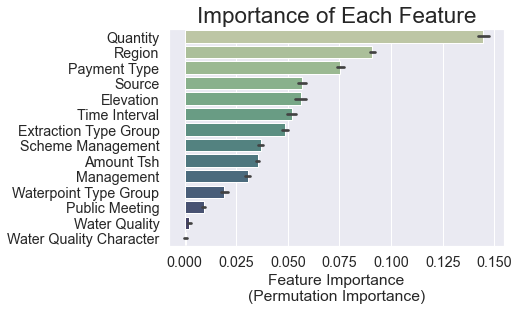

In [100]:
sns.set(font_scale=1.3)
sns.set_palette(sns.cubehelix_palette(14, start=1, rot=-1,dark=.3,light=.8,gamma=1.2))
ax=sns.barplot(data=importance_plot_df,orient='h')
ax.set(xlabel='Feature Importance\n(Permutation Importance)')
loc,labels=plt.yticks();
for z in labels:
    z.set_text(((z.get_text()).title()).replace('_',' '));
    
plt.yticks(loc,labels);
plt.title('Importance of Each Feature',size='x-large')

It should be noted that some features here appear to be quite low in importance, in fact some iterations of the water quality character's results were negative.  This isn't an obvious sign they should be dropped, however; water quality character is probably tightly related to water quality, the extraction method, and the waterpoint type (the nature of the water determines what kind of well is appropriate to dig and what type of delivery mechanism can be used); this will drive down the feature importance of all factors.  With more time and resources, it would be desirable to investigate this further.  